# 1.导入所需要的库

In [1]:
# 导入所需要的库
from __future__ import print_function

import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.optim import lr_scheduler

# 2.CIFAR10数据集的预处理

In [2]:
# 超参数
lr = 1e-2
momentum = 0.9
weight_decay = 5e-4
nepochs = 10
Batch_size = 128

In [3]:
# 数据增强
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # 数据增广
    transforms.RandomHorizontalFlip(),  # 数据增广
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # 数据归一化
])
# transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2471, 0.2435, 0.2616]),#数据归一化

# download the CIFAR10 by torchvision, trainset is a torchvision.datasets object

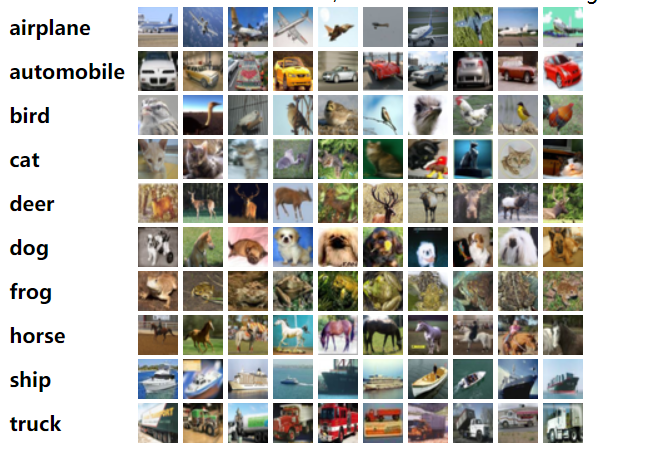

In [4]:
# download the CIFAR10 by torchvision, trainset is a torchvision.datasets object
# transform is performed while obtaining the dataset
# the ./dataset directory is automatically created, and once dowloaded, this code can sense it and will not
# download it again
train_set = torchvision.datasets.CIFAR10('./data', train=True, 
                                         download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10('./data', train=False, 
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=Batch_size, 
                                           shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=Batch_size, 
                                          shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def get_loader(train_set,batch_size=128):
    loader = torch.utils.data.DataLoader(train_set,batch_size = batch_size,
                       num_workers=2,shuffle=True)
    return loader

In [6]:
def get_train_split_data( train_set, train_split = 0.8):
    num_train = len(train_set)
    indices = list(range(num_train))
    split = int(num_train * train_split)
    train_idx, val_idx = indices[:split], indices[split:]
    train_dataset = torch.utils.data.Subset(train_set,train_idx)
    return train_dataset

In [7]:
train_split_loader = []
train_splits = [0.01,0.1,0.5,0.8,1]
for train_split in train_splits:
    train_split_dataset = get_train_split_data(train_set,train_split)
    train_split_loader.append(get_loader(train_split_dataset,Batch_size))

In [8]:
for loader in train_split_loader:
    print(len(loader))

4
40
196
313
391


# Image displaying

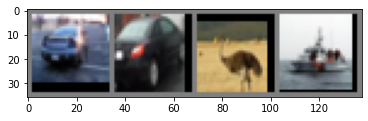

In [9]:
# Image displaying
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # normalizing
    img = img / 2 + 0.5 # imgs are already noramlized during Transforming in data prepration
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # plt.show()

image_iter = iter(train_loader)
images, labels = image_iter.next()
imshow(torchvision.utils.make_grid(images[:4])) 

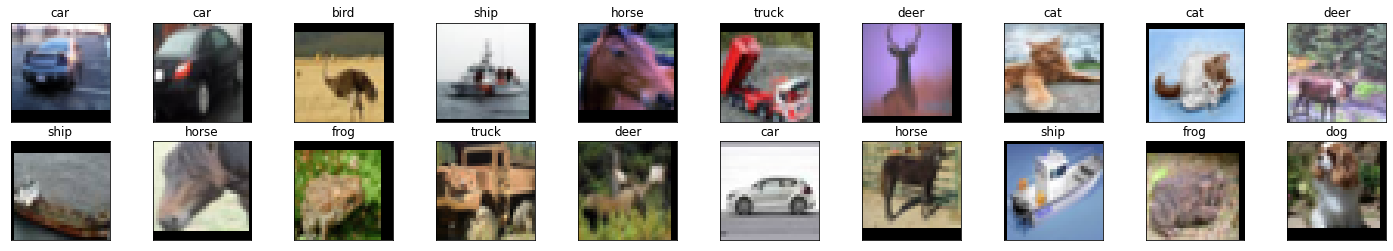

In [10]:
fig = plt.figure(figsize=(25 , 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10 , idx + 1, xticks =[], yticks = []) # 2 行 10 列
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

plt.show()

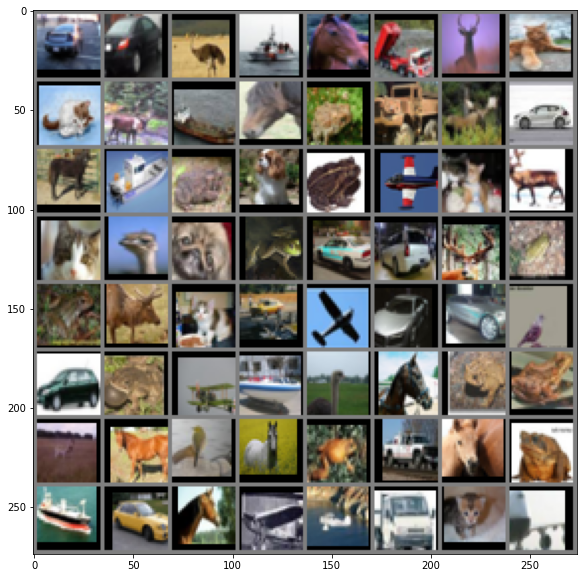

In [11]:
fig = plt.figure(figsize=(50 , 10))
imshow(torchvision.utils.make_grid(images[:64]))

# 测试是否能用GPU

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cpu')
print(device)

cuda


# 构建VGG模型

In [13]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

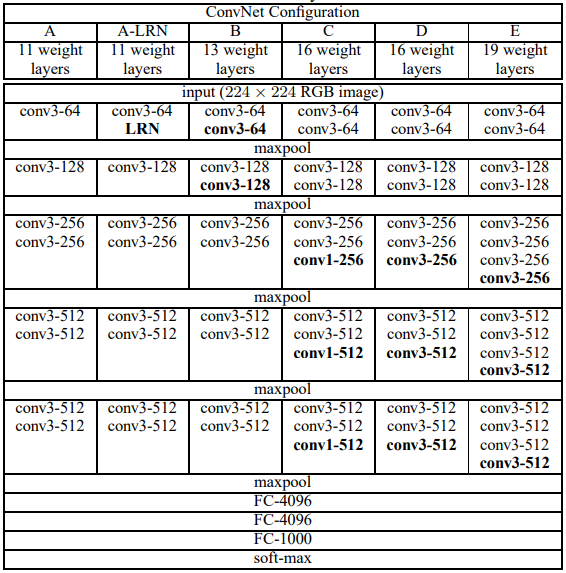

In [14]:
class VGG(nn.Module):
    
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Sequential(
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(512,10),
        )
#         self.classifier = nn.Linear(512,10)

        self._initialize_weight()
        
    def forward(self, x):
        out = self.features(x)
        # 在进入
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out
    
    # make layers
    def _make_layers(self, cfg):
        layers = []
        in_channels = 3 # RGB 初始通道为3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)] # kernel_size 为 2 x 2,然后步长为2
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1), # 都是(3.3)的卷积核
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]  # RelU
                in_channels = x  # 重定义通道
#         layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
    
    # 初始化参数
    def _initialize_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # xavier is used in VGG's paper
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

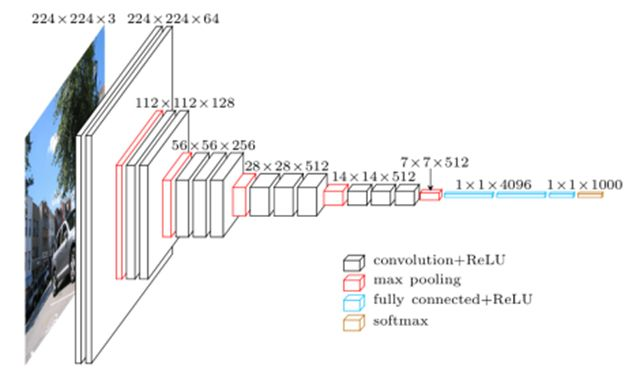

In [15]:
net = VGG('VGG16').to(device)
print(net)
if device == 'cuda':
    net = nn.DataParallel(net)
    # 当计算图不会改变的时候（每次输入形状相同，模型不改变）的情况下可以提高性能，反之则降低性能
    torch.backends.cudnn.benchmark = True

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [16]:
x = torch.randn(2,3,32,32).to(device)
y = net(x)
print(y.shape)

torch.Size([2, 10])


# Training

In [17]:
# 定义训练的辅助函数
def eval(model, loss_func, dataloader):
    model.eval()
    loss,accuracy = 0,0
    
    # torch.no_grad不需要计算梯度
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x,batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x) 
            error = loss_func(outputs,batch_y) # 计算误差
            loss += error.item() 
            
            probs, pred_y = outputs.data.max(dim=1) # 得到概率
            accuracy += (pred_y==batch_y.data).float().sum()/batch_y.size(0) # 准确率
    loss /= len(dataloader)
    accuracy = accuracy*100.0 / len(dataloader)
    return loss, accuracy

def train_epoch(model, loss_func, optimizer, dataloader):
    model.train()
    for batch_x, batch_y in dataloader:
        batch_x,batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad() #将参数的grad值初始化为0
        outputs = model(batch_x)
        error = loss_func(outputs, batch_y)
        # 清理内存
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        error.backward()  # 反向传播
        # 单次优化
        optimizer.step() 

In [18]:
# # Trainin
# def train(epoch):
#     print('\n Epoch: %d' % (epoch + 1))
#     net.train()
#     train_loss = 0
#     correct = 0
#     total = 0
#     for batch_idx, (inputs, targrts) in enumerate(train_loader):
#         inputs , targrts = inputs.to(device) , targrts.to(device)
        
#         optimizer.zero_grad()
#         outputs = net(inputs)
#         # 得到损失
#         loss= criterion(outputs, targrts)
#         # 清理内存
#         if hasattr(torch.cuda, 'empty_cache'):
#             torch.cuda.empty_cache()

#         # 反向传播
#         loss.backward()
#         # 单次优化
#         optimizer.step()
#         # 得到损失
#         train_loss += loss.item()
#         _, predicted = outputs.max(1)
#         total += targrts.size(0)
#         correct += predicted.eq(targrts).sum().item()
#         if batch_idx % 100 == 99:
#             print('[%d, %5d] loss: %.5f |  Acc:%3f%% (%d/%d)'%
#                  (epoch + 1, batch_idx + 1, train_loss / 2000, 100.*correct/total, correct, total))
#             train_loss = 0.0
#             total = 0
#             correct = 0

In [19]:
load_history = False
# load_history = True
if load_history:
    learn_history={'train_loss':[],'train_acc':[],'test_loss':[],'test_acc':[],'lr':[]}
    f = open('history.txt','r')
    lines = f.readlines()
    for line in lines:
        line = line.replace('\n','')
        line = line.split(' ')
        learn_history['train_loss'].append(float(line[0]))
        learn_history['test_loss'].append(float(line[1]))
        learn_history['train_acc'].append(float(line[2]))
        learn_history['test_acc'].append(float(line[3]))
        learn_history['lr'].append(float(line[4]))
    print('load learning history successfully')
else:
    learn_history={'train_loss':[],'train_acc':[],'test_loss':[],'test_acc':[],'lr':[]}

In [20]:
lr = 1e-2
momentum = 0.9
weight_decay = 5e-4
nepochs = 100
# 定义损失函数为交叉熵损失
criterion = nn.CrossEntropyLoss()
# 优化函数
optimizer = optim.SGD(net.parameters(), lr = lr ,momentum= momentum, weight_decay=weight_decay, nesterov=True)
# optimizer = optim.Adam(net.parameters(),lr = lr,weight_decay=weight_decay)
# scheduler = lr_scheduler.MultiStepLR(optimizer,milestones=[5,10,15] , gamma=0.1 ) # 根据指定的milestones 进行学习率的调整
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3,verbose=True,patience = 5,min_lr = 0.000001) # 动态更新学习率
# scheduler = lr_scheduler.StepLR(optimizer, gamma=0.1 ,step_size = 20) 
# opt = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9, weight_decay=1e-4, nesterov=True)
#   lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=50, gamma=0.1)

In [21]:
# # 超参数设置2
# lr = 1e-2
# momentum = 0.9
# weight_decay = 5e-4
# nepochs = 200
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters(),lr = lr,weight_decay=weight_decay)
# # 动态更新学习率
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5,verbose=True,patience = 5,min_lr = 0.000001) # 动态更新学习率

In [22]:
load_model = False
# load_model = True
if load_model:
    checkpoint = torch.load('./checkpoint/vgg.ckpt')
    net.load_state_dict(checkpoint['net'])
    start_epoch = checkpoint['epoch']
else:
    start_epoch = 0
print('start_epoch: %s' % start_epoch)

start_epoch: 0


In [23]:
for epoch in range(nepochs):
    # 训练开始时间
    since = time.time()
#     train_epoch(net, criterion, optimizer, train_loader)
    train_epoch(net,criterion,optimizer,train_split_loader[0])
#     scheduler.step(loss, epoch=epoch)
    # 每训练5轮输出一次结果
#     if (epoch)%5 == 0:
    tr_loss, tr_acc = eval(net, criterion, train_split_loader[0])
    te_loss, te_acc = eval(net, criterion, test_loader)
    learn_history['train_loss'].append(tr_loss)
    learn_history['train_acc'].append(tr_acc)
    learn_history['test_loss'].append(te_loss)
    learn_history['test_acc'].append(te_acc)
    lr = optimizer.param_groups[0]['lr']
    learn_history['lr'].append(lr)
#     print('lr = %f' % optimizer.param_groups[0]['lr'])
    scheduler.step(tr_loss)
#     scheduler.step()
#     scheduler.step(tr_loss)
    # 完成一批次训练的结束时间
    now = time.time()
    print('[%3d/%d, %.0f seconds]|\t loss: %f, accuaracy: %2.2f%%\t|\ttest_loss: %f, test_accuaracy: %2.2f%%\ttrain_lr:%.6f'%
          (epoch+1, nepochs, now-since, tr_loss, tr_acc, te_loss, te_acc,lr))
#     print('学习率lr = %f' % lr)

[  1/100, 33 seconds]|	 loss: 2.302325, accuaracy: 12.90%	|	test_loss: 2.302594, test_accuaracy: 9.96%	train_lr:0.010000
[  2/100, 16 seconds]|	 loss: 2.301883, accuaracy: 12.96%	|	test_loss: 2.302622, test_accuaracy: 9.96%	train_lr:0.010000
[  3/100, 17 seconds]|	 loss: 2.301255, accuaracy: 13.00%	|	test_loss: 2.302681, test_accuaracy: 9.96%	train_lr:0.010000
[  4/100, 16 seconds]|	 loss: 2.300531, accuaracy: 12.94%	|	test_loss: 2.302804, test_accuaracy: 9.96%	train_lr:0.010000
[  5/100, 15 seconds]|	 loss: 2.299764, accuaracy: 13.00%	|	test_loss: 2.302982, test_accuaracy: 9.96%	train_lr:0.010000
[  6/100, 15 seconds]|	 loss: 2.298731, accuaracy: 13.00%	|	test_loss: 2.303215, test_accuaracy: 9.96%	train_lr:0.010000
[  7/100, 16 seconds]|	 loss: 2.297634, accuaracy: 13.08%	|	test_loss: 2.303569, test_accuaracy: 9.96%	train_lr:0.010000
[  8/100, 15 seconds]|	 loss: 2.296629, accuaracy: 12.92%	|	test_loss: 2.304019, test_accuaracy: 9.96%	train_lr:0.010000
[  9/100, 15 seconds]|	 loss: 2.

[ 68/100, 16 seconds]|	 loss: 0.478554, accuaracy: 87.63%	|	test_loss: 2.398484, test_accuaracy: 35.61%	train_lr:0.003000
[ 69/100, 16 seconds]|	 loss: 0.462670, accuaracy: 85.55%	|	test_loss: 2.517580, test_accuaracy: 35.11%	train_lr:0.003000
[ 70/100, 17 seconds]|	 loss: 0.450821, accuaracy: 86.00%	|	test_loss: 2.614301, test_accuaracy: 34.49%	train_lr:0.003000
[ 71/100, 16 seconds]|	 loss: 0.387492, accuaracy: 90.21%	|	test_loss: 2.674647, test_accuaracy: 35.13%	train_lr:0.003000
[ 72/100, 16 seconds]|	 loss: 0.364855, accuaracy: 89.62%	|	test_loss: 2.757113, test_accuaracy: 35.25%	train_lr:0.003000
[ 73/100, 17 seconds]|	 loss: 0.335539, accuaracy: 90.40%	|	test_loss: 2.890922, test_accuaracy: 34.96%	train_lr:0.003000
[ 74/100, 16 seconds]|	 loss: 0.309102, accuaracy: 92.77%	|	test_loss: 2.950336, test_accuaracy: 34.38%	train_lr:0.003000
[ 75/100, 16 seconds]|	 loss: 0.318041, accuaracy: 88.60%	|	test_loss: 3.009447, test_accuaracy: 34.21%	train_lr:0.003000
[ 76/100, 16 seconds]|	 

In [33]:
optimizer.param_groups[0]['lr']

0.003

In [34]:
nepochs = 200
for epoch in range(100,nepochs):
    # 训练开始时间
    since = time.time()
#     train_epoch(net, criterion, optimizer, train_loader)
    train_epoch(net,criterion,optimizer,train_split_loader[0])
#     scheduler.step(loss, epoch=epoch)
    # 每训练5轮输出一次结果
#     if (epoch)%5 == 0:
    tr_loss, tr_acc = eval(net, criterion, train_split_loader[0])
    te_loss, te_acc = eval(net, criterion, test_loader)
    learn_history['train_loss'].append(tr_loss)
    learn_history['train_acc'].append(tr_acc)
    learn_history['test_loss'].append(te_loss)
    learn_history['test_acc'].append(te_acc)
    lr = optimizer.param_groups[0]['lr']
    learn_history['lr'].append(lr)
#     print('lr = %f' % optimizer.param_groups[0]['lr'])
    scheduler.step(tr_loss)
#     scheduler.step()
#     scheduler.step(tr_loss)
    # 完成一批次训练的结束时间
    now = time.time()
    print('[%3d/%d, %.0f seconds]|\t loss: %f, accuaracy: %2.2f%%\t|\ttest_loss: %f, test_accuaracy: %2.2f%%\ttrain_lr:%.6f'%
          (epoch+1, nepochs, now-since, tr_loss, tr_acc, te_loss, te_acc,lr))
#     print('学习率lr = %f' % lr)

[101/200, 22 seconds]|	 loss: 0.114910, accuaracy: 96.23%	|	test_loss: 4.603034, test_accuaracy: 35.27%	train_lr:0.003000
[102/200, 15 seconds]|	 loss: 0.116211, accuaracy: 96.77%	|	test_loss: 4.761438, test_accuaracy: 35.10%	train_lr:0.003000
[103/200, 16 seconds]|	 loss: 0.123826, accuaracy: 96.40%	|	test_loss: 4.608942, test_accuaracy: 34.58%	train_lr:0.003000
Epoch   104: reducing learning rate of group 0 to 9.0000e-04.
[104/200, 16 seconds]|	 loss: 0.177667, accuaracy: 94.39%	|	test_loss: 4.656093, test_accuaracy: 34.64%	train_lr:0.003000
[105/200, 15 seconds]|	 loss: 0.105171, accuaracy: 97.42%	|	test_loss: 4.450865, test_accuaracy: 35.32%	train_lr:0.000900
[106/200, 17 seconds]|	 loss: 0.068109, accuaracy: 99.00%	|	test_loss: 4.449632, test_accuaracy: 35.32%	train_lr:0.000900
[107/200, 16 seconds]|	 loss: 0.059305, accuaracy: 98.81%	|	test_loss: 4.463336, test_accuaracy: 34.65%	train_lr:0.000900
[108/200, 16 seconds]|	 loss: 0.042720, accuaracy: 99.57%	|	test_loss: 4.429978, tes

[167/200, 15 seconds]|	 loss: 0.011634, accuaracy: 100.00%	|	test_loss: 4.785566, test_accuaracy: 36.10%	train_lr:0.000081
[168/200, 14 seconds]|	 loss: 0.011671, accuaracy: 100.00%	|	test_loss: 4.814147, test_accuaracy: 35.95%	train_lr:0.000081
[169/200, 14 seconds]|	 loss: 0.009635, accuaracy: 100.00%	|	test_loss: 4.816999, test_accuaracy: 35.99%	train_lr:0.000081
[170/200, 15 seconds]|	 loss: 0.010890, accuaracy: 100.00%	|	test_loss: 4.822970, test_accuaracy: 36.23%	train_lr:0.000081
[171/200, 14 seconds]|	 loss: 0.010558, accuaracy: 100.00%	|	test_loss: 4.802697, test_accuaracy: 36.05%	train_lr:0.000081
[172/200, 14 seconds]|	 loss: 0.010481, accuaracy: 100.00%	|	test_loss: 4.808332, test_accuaracy: 36.33%	train_lr:0.000081
[173/200, 14 seconds]|	 loss: 0.010797, accuaracy: 100.00%	|	test_loss: 4.821884, test_accuaracy: 36.43%	train_lr:0.000081
[174/200, 15 seconds]|	 loss: 0.009944, accuaracy: 100.00%	|	test_loss: 4.840950, test_accuaracy: 36.16%	train_lr:0.000081
Epoch   175: red

# 保存模型 Save Model

In [35]:
save_model = False
save_model = True
if save_model:
    state = {
        'net':net.state_dict(),# 模型的参数
        'epoch':nepochs
    }
    os.makedirs('checkpoint',exist_ok=True)
    torch.save(state,'./checkpoint/vgg16_train_split_0.01.ckpt')

# 测试模型 Test Model

GroundTruth:    cat  ship  ship plane
Predicted:   frog   car   car  ship
Accuracy of the network on the 10000 test images: 36 %


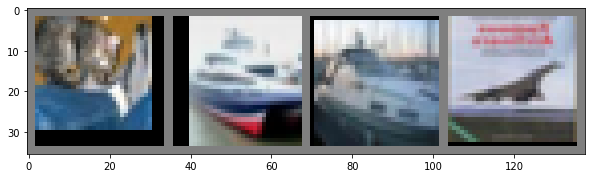

In [36]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images[:4]
labels = labels[:4]
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


outputs = net(images.to(device))
_, predicted = torch.max(outputs.cpu(), 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % 
      (100 * correct / total))


# 查看模型在每一个类的准确率

In [37]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 51 %
Accuracy of   car : 46 %
Accuracy of  bird : 15 %
Accuracy of   cat : 23 %
Accuracy of  deer : 25 %
Accuracy of   dog : 30 %
Accuracy of  frog : 30 %
Accuracy of horse : 32 %
Accuracy of  ship : 43 %
Accuracy of truck : 43 %


# 可视化误差曲线，准确率曲线，学习率曲线

In [38]:
def plot_history(history):
    """
    plot loss and acc history.
    :param history: train returned history object
    """
    epoch_list = range(1,len(history['train_loss'])+1)
    plt.plot(epoch_list, history['train_loss'])
    plt.plot(epoch_list, history['test_loss'])
    plt.xlabel('epoch')
    plt.ylabel('Loss value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(epoch_list, history['train_acc'])
    plt.plot(epoch_list, history['test_acc'])
    plt.xlabel('epoch')
    plt.ylabel('acc value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(epoch_list, history['lr'])
    plt.xlabel('epoch')
    plt.ylabel('Train LR')
    plt.show()

In [39]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

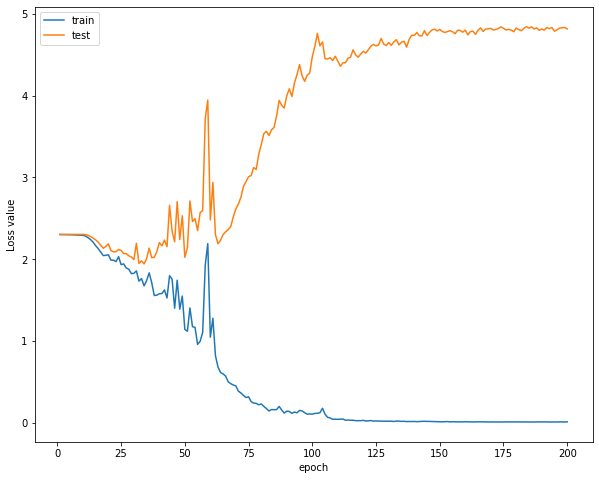

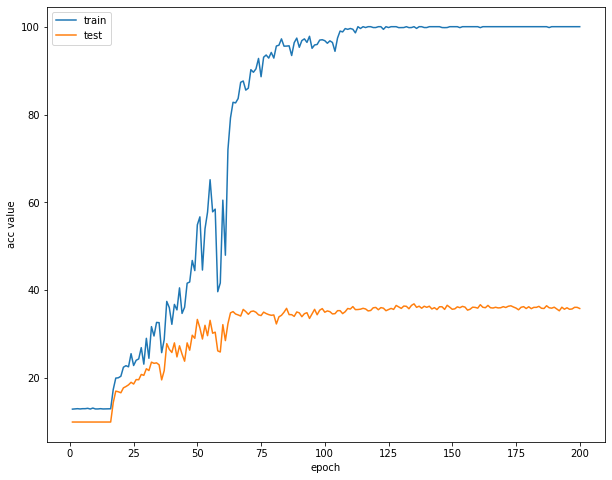

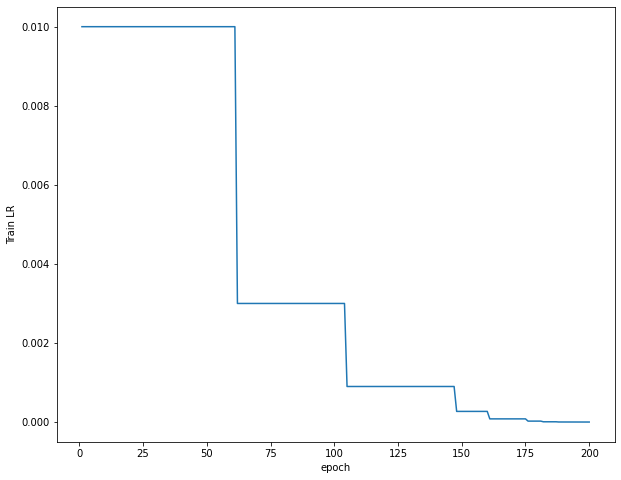

In [40]:
plot_history(learn_history)

# 将数据写入文件

In [41]:
f = open('history_train_split_0.1.txt','a+')
f.write('new\n')
for i in range(len(learn_history['train_loss'])):
#     print( "%f %f %f %f"% (history['train_loss'][i],history['test_loss'][i],history['train_acc'][i],history['test_acc'][i]))
    f.writelines( "%f %f %f %f %f\n"% (learn_history['train_loss'][i],learn_history['test_loss'][i],learn_history['train_acc'][i],learn_history['test_acc'][i],learn_history['lr'][i]))
f.close()